# Computing window matrices with autodiff - isotropic case

The window matrix $\mathrm{W}$ relates the (mean) observed power spectrum $\langle P_o \rangle$
to the power spectrum theory $P_t$: $\langle P_o \rangle = \mathrm{W} P_t$.
In other words, it is just the Jacobian of $\langle P_o \rangle$ w.r.t. $P_t$... which we can hope to compute with autodiff!

In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (generate_gaussian_mesh, ParticleField, FKPField,
compute_mesh_power, compute_fkp_power, compute_normalization)

## Trivial example: box power spectrum

Let's start with the window for the power spectrum of a simulation box. Let's consider the following pipeline, with input the theory power spectrum $P_i$ and output the measured power spectrum $P_o$:

1. generate a Gaussian random field following $P_i$
2. compute the power spectrum of that random field to obtain $P_o$

Then, we take the derivative of $P_o$ w.r.t. $P_i$. Of course, 1) and 2) must be differentiable.

In [2]:
def mock_box(power, unitary_amplitude=False, boxsize=1000., meshsize=128, seed=42):
    mesh = generate_gaussian_mesh(lambda kvec: power(sum(kk**2 for kk in kvec)**0.5), unitary_amplitude=unitary_amplitude, boxsize=boxsize, meshsize=meshsize, seed=seed)
    edges = {'step': 0.01}
    return compute_mesh_power(mesh, edges=edges, los='x')

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


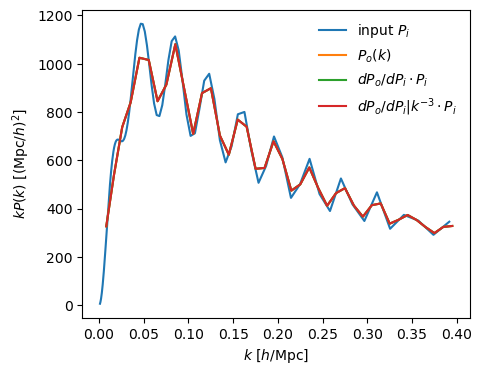

In [3]:
# To highlight the effect of the window convolution,
# we generate a power spectrum with high frequency BAO

from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
kin = jnp.geomspace(1e-3, 1e1, 200)
pkin = pk(kin) * 4 * (1. + 0.2 * np.sin(kin / 0.006))

get_pk = lambda pkin, **kwargs: mock_box(lambda k: jnp.interp(k, kin, pkin, left=0., right=0.), **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power[0].real)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['unitary_amplitude'])
get_wmat = jax.jit(get_wmat, static_argnames=['unitary_amplitude'])

seed = random.key(42)
# Get one power spectrum
pk = get_pk(pkin, seed=seed)
pkt = get_wmat(pkin, seed=seed).dot(pkin)
pkt_km3 = get_wmat(kin**(-3), seed=seed).dot(pkin)
k, edges = pk.k, pk.edges

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
ax.plot(k, k * pk.power[0].real, label='$P_o(k)$')
ax.plot(k, k * pkt, label='$dP_o/dP_i \cdot P_i$')
ax.plot(k, k * pkt_km3, label='$dP_o/dP_i | k^{-3} \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

- blue: input power spectrum $P_i$
- orange: output power spectrum $P_o$
- green: Jacobian $dP_o/dP_i$, evaluated at $P_i$
- red: Jacobian $dP_o/dP_i$, evaluated at $k^{-3}$

The Jacobian does not depend on the input power spectrum, all good!
However, this is for one realization of the initial conditions...
To compute the window matrix, we must average!
In this case, we can just force the amplitude of the initial fluctuations to have unit variance (before product with the input power spectrum).

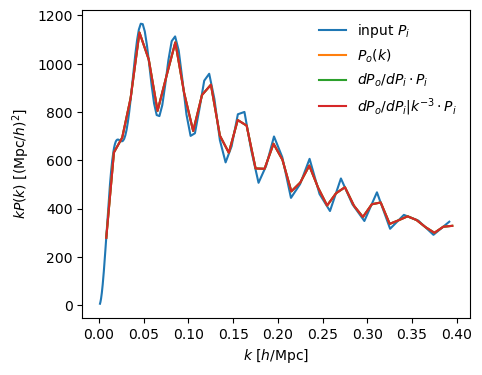

In [4]:
pk_unit = get_pk(pkin, seed=seed, unitary_amplitude=True)
seed = random.key(44)
pk_unit2 = get_pk(pkin, seed=seed, unitary_amplitude=True)
assert np.allclose(pk_unit2.power, pk_unit.power)  # no dependence on the seed with unitary_amplitude=True
pkt_unit = get_wmat(pkin, seed=seed, unitary_amplitude=True).dot(pkin)
pkt_km3_unit = get_wmat(kin**(-3), seed=seed, unitary_amplitude=True).dot(pkin)

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
ax.plot(k, k * pk_unit.power[0].real, label='$P_o(k)$')
ax.plot(k, k * pkt_unit, label='$dP_o/dP_i \cdot P_i$')
ax.plot(k, k * pkt_km3_unit, label='$dP_o/dP_i | k^{-3} \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

## Semi-realistic example: varying selection function

Let's implement a non-trivial survey selection function, e.g. $\bar{n}(x, y, z) \propto e^{-(x^2 + y^2 + z^2) / (0.2 L)}$, with $L = 2000 \, \mathrm{Mpc}/h$ the box size, truncated at the box boundaries.

In [5]:
def gaussian_survey(boxsize=2000., meshsize=128, boxcenter=0., size=int(1e6), seed=random.key(42), scale=0.1, paint=False):
    # Generate Gaussian-distributed positions
    positions = scale * boxsize * random.normal(seed, shape=(size, 3))
    toret = ParticleField(positions + boxcenter, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    if paint: toret = toret.paint(resampler='cic', interlacing=1, compensate=False)
    return toret

def mock_survey(power, selection, unitary_amplitude=True, seed=random.key(42), **kwargs):
    # Generate Gaussian field
    mesh = generate_gaussian_mesh(lambda kvec: power(sum(kk**2 for kk in kvec)**0.5),
                                  boxsize=selection.boxsize, meshsize=selection.meshsize, boxcenter=selection.boxcenter,
                                  unitary_amplitude=unitary_amplitude, seed=seed, **kwargs)
    edges = {'step': 0.005}
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    return compute_mesh_power(mesh * selection, edges=edges).clone(norm=norm)

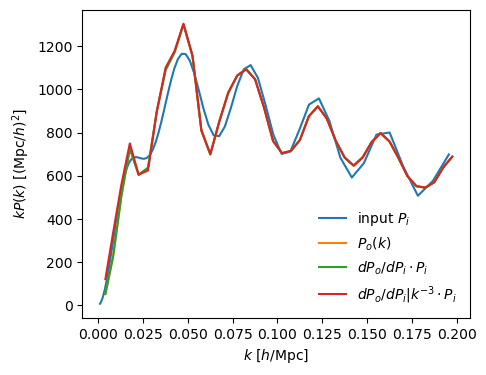

In [6]:
selection = gaussian_survey(size=int(1e7), paint=True)

get_pk = lambda pkin, **kwargs: mock_survey(lambda k: jnp.interp(k, kin, pkin, left=0., right=0.), selection, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power[0].real)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['unitary_amplitude'])
get_wmat = jax.jit(get_wmat, static_argnames=['unitary_amplitude'])
# Same code as in the previous case!
seed = random.key(42)
# Get one power spectrum
pk = get_pk(pkin, seed=seed)
pkt = get_wmat(pkin, seed=seed).dot(pkin)
pkt_km3 = get_wmat(kin**(-3), seed=seed).dot(pkin)
k, edges = pk.k, pk.edges

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
ax.plot(k, k * pk.power[0].real, label='$P_o(k)$')
ax.plot(k, k * pkt, label='$dP_o/dP_i \cdot P_i$')
ax.plot(k, k * pkt_km3, label='$dP_o/dP_i | k^{-3} \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Green is on top of orange, good. But woops, it looks like the derivative $dP_o/dP_i$ depends on the input power spectrum?
Let's try to average!

In [7]:
from tqdm import trange
pks, wmats, pkts, pkts_km3 = [], [], [], []
npk, npkt = 100, 100
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(pkin, seed=seed))
with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(pkin, seed=seed)
        wmats.append(wmat)
        pkts.append(wmat.dot(pkin))
        pkts_km3.append(get_wmat(kin**(-3), seed=seed).dot(pkin))

100%|██████████| 20/20 [04:31<00:00, 13.58s/it]


Note: on the GPU, 40 it/s, so computing window matrices for $\mathcal{O}(100)$ realizations should be largely feasible.

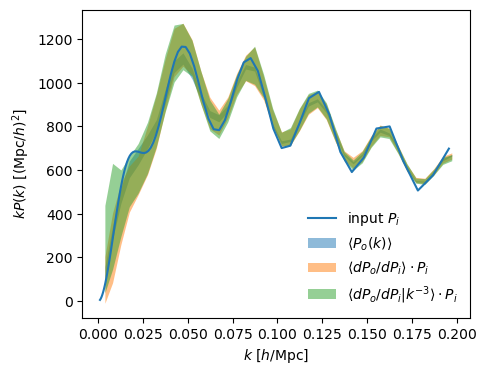

In [8]:
k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power[0].real for pk in pks], axis=0), np.std([pk.power[0].real for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5
pkt_km3_mean, pkt_km3_std = np.mean(pkts_km3, axis=0), np.std(pkts_km3, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
kw = dict(lw=0., alpha=0.5)
ax.fill_between(k, k * (pk_mean - pk_std), k * (pk_mean + pk_std), label=r'$\langle P_o(k) \rangle$', **kw)
ax.fill_between(k, k * (pkt_mean - pkt_std), k * (pkt_mean + pkt_std), label=r'$\langle dP_o/dP_i \rangle \cdot P_i$', **kw)
ax.fill_between(k, k * (pkt_km3_mean - pkt_std), k * (pkt_km3_mean + pkt_km3_std), label=r'$\langle dP_o/dP_i | k^{-3} \rangle \cdot P_i$', **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Looks all good!

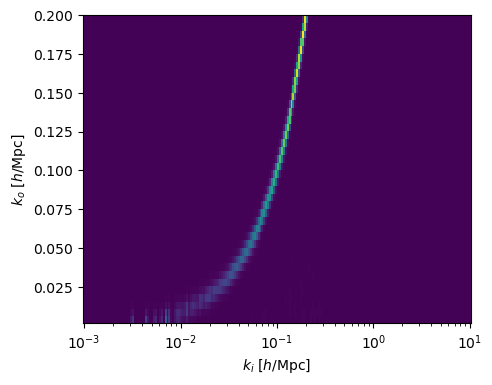

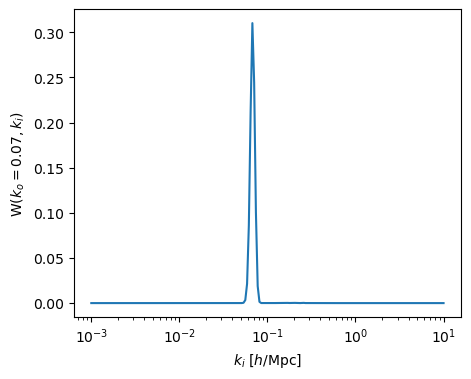

In [9]:
wmat = np.mean(wmats, axis=0)
ax = plt.gca()
ax.pcolormesh(kin, k, wmat)
ax.set_xscale('log')
ax.set_ylabel(r'$k_o$ [$h/\mathrm{Mpc}$]')
ax.set_xlabel(r'$k_i$ [$h/\mathrm{Mpc}$]')
plt.show()

ax = plt.gca()
ax.plot(kin, wmat[np.argmin(np.abs(k - 0.07))])
ax.set_xscale('log')
ax.set_xlabel(r'$k_i$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$\mathrm{W}(k_o=0.07, k_i)$')
plt.show()

## Adding some shot noise
Instead of "meshes" as above, here we generate a Gaussian mock in terms of particle positions and weights... Just to check there is nothing crazy happening.

In [17]:
def mock_survey_noise(power, boxsize=2000., meshsize=128, size=int(1e6), seed=random.key(42), unitary_amplitude=False):
    # Generate Gaussian field
    seeds = random.split(seed, 4)
    # randoms
    randoms = gaussian_survey(boxsize=boxsize, meshsize=meshsize, size=size, seed=seeds[0], paint=False)
    # data
    data = gaussian_survey(boxsize=boxsize, meshsize=meshsize, size=size, seed=seeds[1], paint=False)
    # field
    mesh = generate_gaussian_mesh(lambda kvec: power(sum(kk**2 for kk in kvec)**0.5),
                                  boxsize=randoms.boxsize, meshsize=randoms.meshsize,
                                  boxcenter=0., unitary_amplitude=unitary_amplitude, seed=seeds[2])
    # weights = 1 + delta
    data = data.clone(weights=data.weights * (1. + mesh.read(data.positions, resampler='cic', compensate=True)))
    edges = {'step': 0.005}
    fkp = FKPField(data, randoms)
    power = compute_fkp_power(fkp, edges=edges, resampler='tsc', interlacing=3)
    return power

get_pk = lambda pkin, **kwargs: mock_survey_noise(lambda k: jnp.interp(k, kin, pkin, left=0., right=0.), **kwargs)
# Below is same code as above
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power[0].real)(pkin)
get_pk = jax.jit(get_pk)
get_wmat = jax.jit(get_wmat)

from tqdm import trange
pks, wmats, pkts, pkts_km3 = [], [], [], []
npk, npkt = 100, 100
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(pkin, seed=seed))

with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(pkin, seed=seed)
        wmats.append(wmat)
        pkts.append(wmat.dot(pkin))
        pkts_km3.append(get_wmat(kin**(-3), seed=seed).dot(pkin))

k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power[0].real for pk in pks], axis=0), np.std([pk.power[0].real for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5
pkt_km3_mean, pkt_km3_std = np.mean(pkts_km3, axis=0), np.std(pkts_km3, axis=0) / npkt**0.5

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


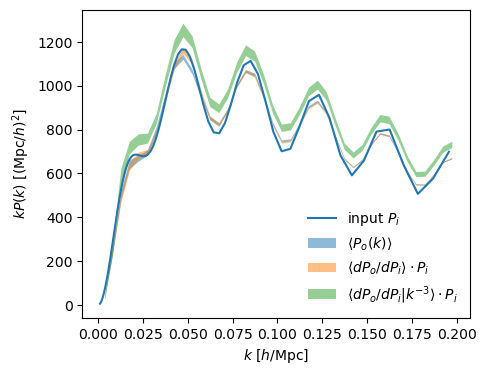

In [19]:
ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
kw = dict(lw=0., alpha=0.5)
ax.fill_between(k, k * (pk_mean - pk_std), k * (pk_mean + pk_std), label=r'$\langle P_o(k) \rangle$', **kw)
ax.fill_between(k, k * (pkt_mean - pkt_std), k * (pkt_mean + pkt_std), label=r'$\langle dP_o/dP_i \rangle \cdot P_i$', **kw)
ax.fill_between(k, k * (pkt_km3_mean - pkt_std), k * (pkt_km3_mean + pkt_km3_std), label=r'$\langle dP_o/dP_i | k^{-3} \rangle \cdot P_i$', **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

On a GPU node, 2.5 it/s.

I have checked that the offset for the green curve is related to the normalization, i.e. with ```power.clone(norm=1.)``` all power spectrum measurements are on top of each other.